In [3]:
import pandas as pd
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import os

import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions


In [10]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/nbeats_TEST"
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data From File

In [11]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.392,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.392,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.392,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.203,...,-1.087,31.561,5.159e+10,4.979e+10,4.075e+10,3.661e+09,3.111e+09,2.546e+09,4259.604,4307.137
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.240,...,1.990,18.580,5.106e+10,5.205e+10,4.156e+10,3.780e+08,1.129e+09,9.018e+08,4276.202,4323.730
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.251,...,-2.312,14.723,5.245e+10,5.115e+10,4.060e+10,1.300e+09,2.674e+09,2.123e+09,4316.303,4337.489
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.262,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


In [13]:
dataset_df = foodprice_df[foodprice_categories].T
dataset_df

,1986-01-01,1986-02-01,1986-03-01,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,...,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01
Bakery and cereal products (excluding baby food),69.3,70.3,70.6,71.3,71.2,71.1,71.7,71.9,71.7,71.1,...,154.2,157.1,156.8,156.2,157.8,157.7,157.9,158.5,158.1,159.3
Dairy products and eggs,70.9,70.8,71.1,71.0,71.4,71.1,71.3,71.5,71.8,71.8,...,141.6,143.1,144.9,146.1,146.6,145.3,146.4,148.3,148.0,146.6
"Fish, seafood and other marine products",60.6,61.3,61.3,61.4,61.9,62.0,62.2,62.7,63.1,63.6,...,143.4,143.9,144.9,145.1,147.6,146.2,146.6,146.8,147.1,149.3
Food purchased from restaurants,59.1,59.1,59.3,59.7,59.9,60.0,60.6,60.9,60.9,61.3,...,162.6,162.9,162.6,163.2,163.5,163.9,165.2,165.9,165.9,167.1
Food,67.3,66.9,67.0,67.7,68.2,68.4,69.2,69.5,69.9,70.2,...,155.0,155.6,155.5,155.4,156.6,156.8,157.6,158.0,158.5,159.2
"Fruit, fruit preparations and nuts",76.0,77.6,79.2,82.2,83.5,83.1,84.8,86.7,83.8,82.9,...,140.9,143.4,142.4,141.9,143.9,144.5,141.7,142.5,141.5,141.7
Meat,65.1,64.2,64.2,63.6,64.0,64.9,66.5,67.8,71.3,71.5,...,171.9,169.5,170.2,173.5,175.4,176.7,180.9,182.1,184.8,187.1
Other food products and non-alcoholic beverages,77.5,78.1,78.6,79.5,79.8,79.9,80.2,80.2,80.8,81.0,...,139.0,139.5,141.5,140.5,141.6,142.2,141.9,141.7,144.3,144.4
Vegetables and vegetable preparations,76.0,68.4,66.2,71.1,75.3,74.1,75.7,71.9,66.6,70.7,...,162.5,163.8,157.4,151.1,153.8,153.4,154.8,152.2,150.0,149.4


In [15]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

## Fit Models Using All Data To Produce Final Forecast

TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/ethan/anaconda3/envs/foodprice/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/ethan/anaconda3/envs/foodprice/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/Users/ethan/anaconda3/envs/foodprice/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/Users/ethan/anaconda3/envs/foodprice/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version


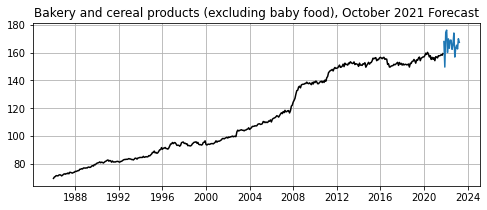

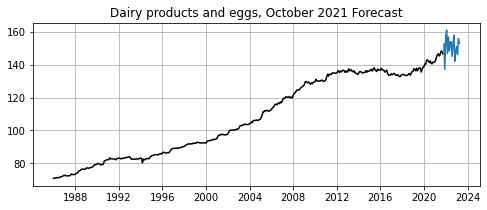

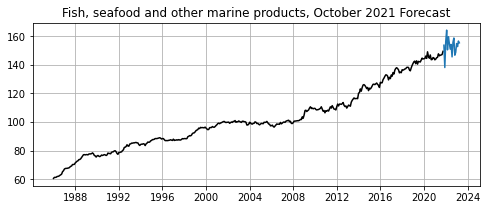

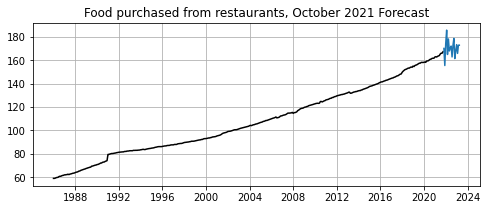

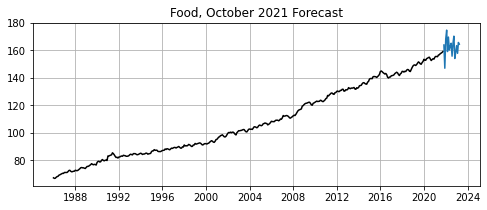

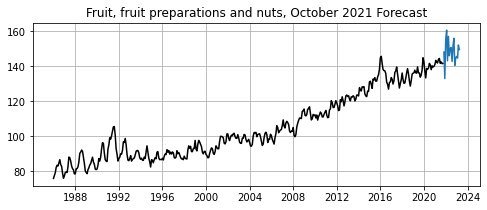

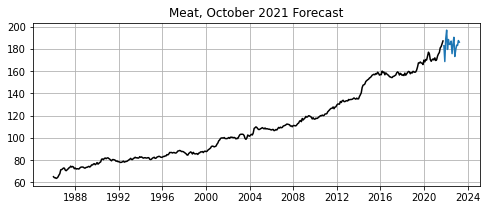

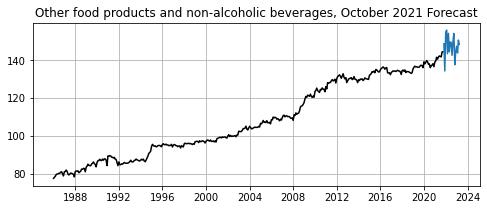

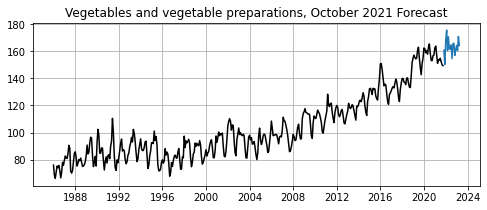

In [16]:
cutoff_date = "2021-10-01"
prediction_length = 18

train_dates = foodprice_df.loc[foodprice_df.index <= cutoff_date].index

train_ds = ListDataset(
    [{'target': x, 'start': train_dates[0]} for x in dataset_df[list(train_dates)].values],
    freq='MS'
)

# Need to add empty forecast dates since make_evaluation_predictions will cut off prediction_length many entries.

forecast_dates = pd.date_range(pd.to_datetime(cutoff_date) + pd.DateOffset(months=1), pd.to_datetime(cutoff_date) + pd.DateOffset(months=prediction_length), freq='MS')

extra_series = []
for date in forecast_dates:
    extra_series.append(pd.Series(np.zeros_like(dataset_df.index), name=date, index=dataset_df.index))

forecast_df = dataset_df.join(extra_series)

forecast_ds = ListDataset(
    [{'target': x, 'start': train_dates[0]} for x in forecast_df[list(train_dates) + list(forecast_dates)].values],
    freq='MS'
)

estimator = NBEATSEnsembleEstimator(
    prediction_length=prediction_length,
    meta_bagging_size = 3,  # 3
    meta_context_length = [prediction_length * m for m in [3,5,7]], 
    meta_loss_function = ['sMAPE'], 
    num_stacks = 30,
    widths= [512],
    freq="MS",
    trainer=Trainer(
                epochs=1,  # 50
                ctx=mx.context.cpu()
            )

)

predictor = estimator.train(train_ds)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=forecast_ds,  # train dataset
    predictor=predictor,  # predictor
)

forecasts = list(forecast_it)

all_food_metrics = {}
food_forecasts = {}

for target_index in range(len(forecasts)):

    # Get food price category
    foodprice_category = foodprice_df.columns[target_index]

    # plot actual
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(train_dates, foodprice_df[foodprice_category][train_dates], color='black')

    # plot forecast
    forecast_entry = forecasts[target_index]
    ax.plot(forecast_dates, forecast_entry.mean[:len(forecast_dates)], color='C0')

    plt.title(f"{foodprice_category}, October 2021 Forecast")
    plt.grid()
    plt.show()

    food_forecasts[foodprice_category] = pd.Series(forecast_entry.mean, index=forecast_dates, name=foodprice_category)

all_forecasts = pd.DataFrame(food_forecasts)
all_forecasts.to_csv(f"{output_path}/fc_final.csv")